In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sys
print (sys.version) 

import statsmodels.api as sm  
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")


3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]


In [64]:
!python --version

Python 3.5.3 :: Anaconda custom (64-bit)


In [65]:
%%time
# df = pd.read_excel('/Users/mikeludwig/Dropbox/city_data/Anonymized_20161006_DOT_Labor_for_PY_2011-12_to_2016-17_PP06_Ending_09172016.xlsx')
df = pd.read_excel('C:/Users/382365/Downloads/Anonymized_20161006_DOT_Labor_for_PY_2011-12_to_2016-17_PP06_Ending_09172016.xlsx')

Wall time: 3min 57s


In [66]:
# Copyright 2017, Mike Ludwig, All rights reserved.
import config
aws_access_key_id = config.aws_access_key_id
aws_secret_access_key = config.aws_secret_access_key


SENDGRID_API_KEY = config.SENDGRID_API_KEY

template_id = config.template_id

# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import datetime

import sys
print (sys.version) 

import statsmodels.api as sm  
sns.set_style('darkgrid')


import sendgrid
import os
from sendgrid.helpers.mail import *
import base64
import time
import io
import matplotlib.dates as mdates
import boto
from datetime import timedelta, date
from boto.s3.connection import S3Connection

seq_col_brew = sns.color_palette('Set2')
sns.set_palette(seq_col_brew)


def emps_morethan_std(df, jobtitle, workdate, varcode):
    #use masks
    jobtitle_mask = (df['JOB_CLASS_TITLE']== jobtitle)
    workdate_mask = (df['WORK_DATE']== workdate)
    varcode_mask = (df['Var Code']== varcode)
    new_df = df[jobtitle_mask & workdate_mask & varcode_mask]
    return new_df[(new_df.HOURS- new_df.HOURS.mean())>(new_df.HOURS.std())][['WORK_DATE', 'EMPLOYEE_NAME', 'HOURS']]

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

def more_than_std_in_range(df, jobtitle, start_date, end_date, varcode):
    appended_data = []
    for single_date in daterange(start_date, end_date):
        data = (emps_morethan_std(df, jobtitle, single_date, varcode))
        appended_data.append(data)
    return pd.concat(appended_data).reset_index(drop=True)

def get_everybody_in(df, jobtitle, start_date, end_date, varcode):
    jobtitle_mask = (df['JOB_CLASS_TITLE']== jobtitle)
    workdate_mask = (df['WORK_DATE'].isin(pd.date_range(start_date, end_date)))
    varcode_mask = (df['Var Code']== varcode)
    new_df = df[jobtitle_mask & workdate_mask & varcode_mask]
    return new_df


def assign_colors(df):
    names_group = df.groupby('EMPLOYEE_NAME')['HOURS'].sum().sort_values(ascending = False)
    names_list = names_group.index.get_level_values(0).tolist()
    return names_list 


def mean_n_outliers_plot(main_df, outlier_df, color_names):
    n = len(color_names)
    sns.set_palette(sns.color_palette('RdBu', n))
    g = sns.FacetGrid(outlier_df, hue='EMPLOYEE_NAME', hue_order=color_names, legend_out=True, size = 8, aspect = 2)
    g.map(plt.plot, 'WORK_DATE', 'HOURS', marker = 'o', linestyle = 'None')
    g.ax.set_title('OVERTIME HOURS BY PAY PERIOD')
    g.ax.xaxis.set_major_locator(mdates.DayLocator())
    g.ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in g.ax.get_xticklabels():
        item.set_rotation(45)
    roll = main_df.groupby('WORK_DATE')['HOURS']
    m = roll.agg(['mean', 'std'])
    ax = m['mean'].plot()
    ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)
    plt.tight_layout()
    sns.plt.legend(loc='lower left', ncol=4, bbox_to_anchor=(-.05,-.5), title="Employee Name", fontsize=16)
    sns.despine()

    
def get_last_13_mos(df, jobtitle, start_date, end_date, varcode):
    new_start = end_date - pd.Timedelta(days=395)
    new_df = get_everybody_in(df, jobtitle, new_start, end_date, varcode).reset_index(drop=True)
    new_df.index = new_df['WORK_DATE']
    del new_df['WORK_DATE']
    month_mean_df = new_df.resample("M", closed='left', label = 'left').mean()
    month_total_df = new_df.resample("M", closed='left', label = 'left').sum()
    return [month_mean_df['HOURS'], month_total_df['HOURS']]


def plot_13mo_mean_n_total(mean_13_months_df, total_13_months_df):
    fig = plt.figure()
    fig.suptitle("Overtime for the Past 13 Months", fontsize=16)
    ax1 = fig.add_subplot(211)
    ax1.plot(mean_13_months_df,  marker = 's')
    ax1.set_title('MEAN HOURS')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax1.get_xticklabels():
        item.set_rotation(45)
    ax1.figure.autofmt_xdate()
    fig.subplots_adjust(hspace=3.5)
    ax2 = fig.add_subplot(212)
    ax2.plot(total_13_months_df,  marker = 's') 
    ax2.set_title('TOTAL HOURS')
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax2.get_xticklabels():
        item.set_rotation(45)
    ax2.figure.autofmt_xdate()
    plt.tight_layout(h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    sns.despine()

    
def get_mplusstd(df, jobtitle, start_date, end_date, varcode):
    new_start = end_date - pd.Timedelta(days=195)
    new_df = get_everybody_in(df, jobtitle, new_start, end_date, varcode).reset_index(drop=True)
    new_df.index = new_df['WORK_DATE']
    del new_df['WORK_DATE']
    roll = new_df.groupby('WORK_DATE')['HOURS']
    m = roll.agg(['mean', 'std'])
    return m['mean'] + m['std']


def plot_mplusstd(test_df, order_vars, seasonal_vars):
    fig= plt.figure(figsize=(10, 6))
    
    fig.suptitle("Overtime Hours for the Past 6 Months", fontsize=18)
    ax1 = fig.add_subplot(211)
    results = get_fitted_model(test_df, order_vars, seasonal_vars)
    pred_uc = results.get_forecast(steps=14)
    pred_ci = pred_uc.conf_int()
    ax1.plot(test_df)
    pred_uc.predicted_mean.plot(ax=ax1, label='Forecast', linewidth = 2.2)
    ax1.fill_between(pred_ci.index,
                       pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax1.set_title('MEAN HOURS + ONE STANDARD DEVIATION')
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%Y'))
    for item in ax1.get_xticklabels():
        item.set_rotation(45)
    ax1.figure.autofmt_xdate()
    plt.tight_layout()
    fig.subplots_adjust(top=0.88)
    sns.despine()
    
      
def plot_increasing_more_than_std(data, color):  
    data = clean_for_time(data)
    observed_dates = data.index.asi8
    observed_values = data['HOURS']
    predict_dates = pd.date_range(data.index[0], 
                                  data.index[0] + pd.DateOffset(days=28), 
                                  freq="D")
    model = np.polyfit(observed_dates, observed_values, 1)
    predicted = np.polyval(model, predict_dates.asi8)
    plt.plot(data.index, data['HOURS'], marker='o', label = 'Overtime')
    plt.plot(predict_dates, predicted, 'b', linewidth=2, label = 'Trend Line')
   
    
def make_increasing_plot(df, trending_list):
    new_df = df[df['EMPLOYEE_NAME'].isin(trending_list)]
    g = sns.FacetGrid(new_df, col="EMPLOYEE_NAME", size=3, aspect=2, col_wrap=3)
    g.map_dataframe(plot_increasing_more_than_std)
    r_baseline = df['HOURS'].mean() + df['HOURS'].std()
    for ax in g.axes.ravel():
        ax.axhline(y=r_baseline, color = 'r', linestyle='dashed',  label='Group Mean Range for Pay Period')
    plt.tight_layout()
    sns.despine()

    
def clean_for_time(df):
    new_df = df.set_index('WORK_DATE')
    new_df = new_df.groupby(new_df.index).agg({'EMPLOYEE_NAME': 'first',
                                'HOURS': 'sum'})
    return new_df.asfreq("D", method='bfill')


def plot_hours_dist(df):
    sns.distplot(df['HOURS'])
    plt.axvline(x= df['HOURS'].mean(), color = 'k')
    plt.axvline(x= df['HOURS'].mean() + df['HOURS'].std(), linestyle = 'dashed', color = 'b')
    plt.axvline(x= df['HOURS'].mean() - df['HOURS'].std(), linestyle = 'dashed', color = 'b')

    
def plot_bars_highOT(outlier_df, color_names):
    n = len(color_names)
    sns.set_palette(sns.color_palette('RdYlBu', n))
    fig = plt.figure(figsize = (7,6))
    df2 = outlier_df.groupby('EMPLOYEE_NAME')['HOURS'].sum().sort_values(ascending = False)
    ax = sns.barplot(y = 'EMPLOYEE_NAME', x = 'HOURS',  data=df2.reset_index())
    ax.set(xlabel='Total Hours', ylabel='Employee Name')
    fig.suptitle('Highest Overtime Users for the Past Pay Period')
    plt.tight_layout(h_pad=1.0)
    fig.subplots_adjust(top=0.88)
    sns.despine()


def run_analysis(df, job_title, start_date, end_date, var_code):
    #use masks to create filtered dataframe, 
    outlier_df = more_than_std_in_range(df, job_title, start_date, end_date, var_code)
    relevant_df = get_everybody_in(df, job_title, start_date, end_date, var_code).reset_index(drop=True)
#     trend_high_list = is_trending_too_high(relevant_df)
    color_names = assign_colors(outlier_df)
    mean_n_outliers_plot(relevant_df, outlier_df, color_names)
    plt.savefig('means_n_outliers.png', format='png', bbox_inches='tight')
    # *save_to_s3('means_n_outliers', job_title, end_date)
    test_df = get_mplusstd(df, a, start_date, end_date, b)
    plot_mplusstd(test_df,  order_vars =(1, 0, 1), seasonal_vars =(1, 1, 1, 7))
    plt.savefig('13mo_mean_n_total.png', format='png', bbox_inches='tight')
    # *save_to_s3('13mo_mean_n_total', job_title, end_date)
    increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
    generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
    plt.savefig('is_increasing.png', format='png', bbox_inches='tight')
    # *save_to_s3('is_increasing', job_title, end_date)
    plot_bars_highOT(outlier_df, color_names)
    plt.savefig('hours_dist.png', format='png', bbox_inches='tight')
    # *save_to_s3('hours_dist', job_title, end_date)

def save_to_s3(name, job_title, end_date):  
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight')
    img_data.seek(0) 
    s3 = boto.connect_s3(aws_access_key_id, aws_secret_access_key)
    bucket = s3.get_bucket('mikes-charts')
    file_name = job_title.lower().replace(" ", "_")
    time_email = time.strftime("%Y%m%d")
    time_created = end_date.strftime("%Y%m%d")
    key = bucket.new_key(file_name + '/'+ time_email + '/'+ time_created +'/'+ name + '.png')
    key.set_contents_from_file(img_data, headers = {'Content-Disposition':'inline'})
    key.set_canned_acl('public-read')
    plt.close()  
    

def send_email(SENDGRID_API_KEY, template_id, job_title, end_date):
#     replacement_url = 'https://s3-us-west-1.amazonaws.com/mikes-charts/examples/controller_logo_med'
#     yrplus_mean_n_total_url, hours_dist_url, is_increasing_url, means_n_outliers_url  = get_urls_from_s3(job_title, end_date)
    sg = sendgrid.SendGridAPIClient(apikey = SENDGRID_API_KEY)
    from_email = Email("test@example.com")
    typed_email_address = input('Send email to what address?  --> ')
    to_email = Email(typed_email_address)
    subject = "This is a test"
    content = Content("text/html", "Let's see if this works!")
    mail = Mail(from_email, subject, to_email, content)
    mail.template_id = template_id
#     mail.personalizations[0].add_substitution(Substitution('~city_logo~', replacement_url))
#     mail.personalizations[0].add_substitution(Substitution('~means_n_outliers~', means_n_outliers_url))
#     mail.personalizations[0].add_substitution(Substitution('~13mo_mean_n_total~', yrplus_mean_n_total_url))
#     mail.personalizations[0].add_substitution(Substitution('~is_increasing~', is_increasing_url))
#     mail.personalizations[0].add_substitution(Substitution('~hours_dist~',  hours_dist_url))
    response = sg.client.mail.send.post(request_body=mail.get())
    print(response.status_code)
    print(response.body)
    print(response.headers)

    
def get_prefix(job_title, end_date):
    file_name = job_title.lower().replace(" ", "_")
    time_email = time.strftime("%Y%m%d")
    time_created = end_date.strftime("%Y%m%d")
    return (file_name + '/'+ time_email + '/'+ time_created +'/')

def get_urls_from_s3(job_title, end_date):
    conn = boto.connect_s3(aws_access_key_id, aws_secret_access_key)
    bucket = conn.get_bucket('mikes-charts')
    url_list = []
    folder_name = get_prefix(job_title, end_date)
    bucket_entries = bucket.list(prefix= folder_name)
    for entry in bucket_entries:
        url = entry.generate_url(expires_in=0, query_auth=False, force_http=True)
        url_list.append(url)
    return url_list

# create function accepting a single parameter, the year as a four digit number
def get_random_date(year):
    # try to get a date
    try:
        return datetime.datetime.strptime('{} {}'.format(random.randint(1, 366), year), '%j %Y')

    # if the value happens to be in the leap year range, try again
    except ValueError:
        get_random_date(year)
        
# seq_col_brew = sns.color_palette('Set2')
# sns.set_palette(seq_col_brew)


def plot_hours_dist(df):
    seq_col_brew = sns.color_palette('Set2')
    sns.set_palette(seq_col_brew)
    sns.distplot(df['HOURS'])
    plt.axvline(x= df['HOURS'].mean(), color = 'k')
    plt.axvline(x= df['HOURS'].mean() + df['HOURS'].std(), linestyle = 'dashed', color = 'b')
    plt.axvline(x= df['HOURS'].mean() - df['HOURS'].std(), linestyle = 'dashed', color = 'b')


def add_in_data(df, end_date):
    start = df.index.min().date() 
    end = end_date + pd.Timedelta(1, 'D')
    return df.reindex(pd.date_range(start, end, freq='D', closed='left')).fillna(method='ffill')


def get_baseline(df, relevant_df, relevant_end_date):
    job_class = relevant_df['JOB_CLASS_TITLE'][0]
    var_code = relevant_df['Var Code'][0]
    jobclass_df = df[(df['JOB_CLASS_TITLE']==job_class) & (df['Var Code']== var_code) & (df['WORK_DATE']<=relevant_end_date)].groupby('WORK_DATE')
    jobclass_mean = jobclass_df['HOURS'].mean()
    jobclass_std = jobclass_df['HOURS'].std()
    jobclass_mstd = jobclass_mean+jobclass_std
    jobclass_mstd = jobclass_mstd[jobclass_mstd.notnull()]
    return jobclass_mstd.asfreq("D", method='bfill')
    
    

def get_fitted_model(tseries, order_vars, seasonal_vars):
    mod = sm.tsa.statespace.SARIMAX(tseries,
                                order = order_vars,
                                seasonal_order = seasonal_vars,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    return mod.fit()



def filter_increasing(df, increase_list, start_date, end_date, job_title, var_code):
    increase_mask = (df['EMPLOYEE_NAME'].isin(increase_list))
    date_mask = (df['WORK_DATE']<=end_date) & (df['WORK_DATE']>=start_date)
    var_mask = (df['Var Code']== var_code)
    data = df[increase_mask & date_mask & var_mask]
    g = data.groupby('EMPLOYEE_NAME').filter(lambda x: len(x) > 5)
    return g['EMPLOYEE_NAME'].unique().tolist()



def is_trending_too_high(df, relevant_df, order_vars, seasonal_vars):
    relevant_names = relevant_df['EMPLOYEE_NAME'].unique()
    relevant_end_date = relevant_df['WORK_DATE'].max().date()
    rel_earlier_date = relevant_end_date -  pd.Timedelta(194, 'D')
    job_class = relevant_df['JOB_CLASS_TITLE'][0]
    var_code =  relevant_df['Var Code'][0]
    best_names = filter_increasing(df, relevant_names, rel_earlier_date, relevant_end_date, job_class, var_code)
    better_df = df[df['EMPLOYEE_NAME'].isin(best_names)]
    better_df = better_df[better_df['WORK_DATE']<=relevant_end_date]
    grps = better_df.groupby(['EMPLOYEE_NAME'])
    baseline = get_baseline(df, relevant_df, relevant_end_date)
    base_pred = get_fitted_model(baseline, order_vars, seasonal_vars).forecast(steps = 14)
    increase_list = []
    for fid, grp in grps:
        if len(grp)>2:
            new_df = clean_for_time(grp)
            new_df = add_in_data(new_df, relevant_end_date)
            results = get_fitted_model(new_df['HOURS'], order_vars, seasonal_vars)
            pred = results.forecast(steps=14)
            if np.all(pred > base_pred):
                increase_list.append(fid)
    return increase_list
  

    
def get_employee_OT(emp_name):
    new_df = df[df['EMPLOYEE_NAME']== emp_name]
    return new_df[new_df['Var Code']=='PA'].reset_index(drop=True)


from cycler import cycler
import itertools

def generate_plot(increase_list, end_date, df, order_vars, seasonal_vars):
    sns.set(context = 'talk')
#     generate plot with:
#     show 2 months before, prediction two weeks before, and two weeks into the future
#     past prediction (2 weeks before) of baseline/employee overtime (with confidence intervals)
#     forecast of baseline/empl oyee overtime (with confidence intervals)
    num_names = len(increase_list)
    palette = itertools.cycle(sns.color_palette("Dark2", n_colors=2*num_names))
    fig = plt.figure(figsize=(16, 4*num_names))
    for i, name in enumerate(increase_list):
        c=next(palette)
        ax = fig.add_subplot(num_names, 1, i+1)
        better_df = clean_for_time(get_employee_OT(name))[:end_date]
        new_df = add_in_data(better_df, end_date)
        results = get_fitted_model(new_df['HOURS'], order_vars, seasonal_vars)
        pred_uc = results.get_forecast(steps=14) 
        # Get confidence intervals of forecasts
        pred_ci = pred_uc.conf_int()
        # We can use the output of this code to plot the time series and forecasts of its future values.
        earlier_date = end_date -  pd.Timedelta(194, 'D')
        better_df.ix[earlier_date: ].plot(ax=ax, label='observed', c=c)
        pred_uc.predicted_mean.plot(ax=ax, label='Forecast', linewidth = 2.2, c = next(palette))
        ax.fill_between(pred_ci.index,
                        pred_ci.iloc[:, 0],
                        pred_ci.iloc[:, 1], color='k', alpha=.25)
        ax.set_title(name)
        ax.set_xlabel('Date')
        ax.set_ylabel('Overtime Hours')
        # Set major x ticks on Mondays.
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))
        plt.legend()
    plt.tight_layout()
    sns.despine()


def main():
    start_date = input('Start Date?  --> ')
    end_date = input('End Date?  --> ')
    job_class = input('Job Class Title?  --> ')  
    OT_code = input('OT Var Code?  --> ') 
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    run_analysis(df, job_class, start_date, end_date, OT_code)
    send_email(SENDGRID_API_KEY, template_id, job_class, end_date)



3.5.3 |Anaconda custom (64-bit)| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]


In [67]:
# %%time
# main()


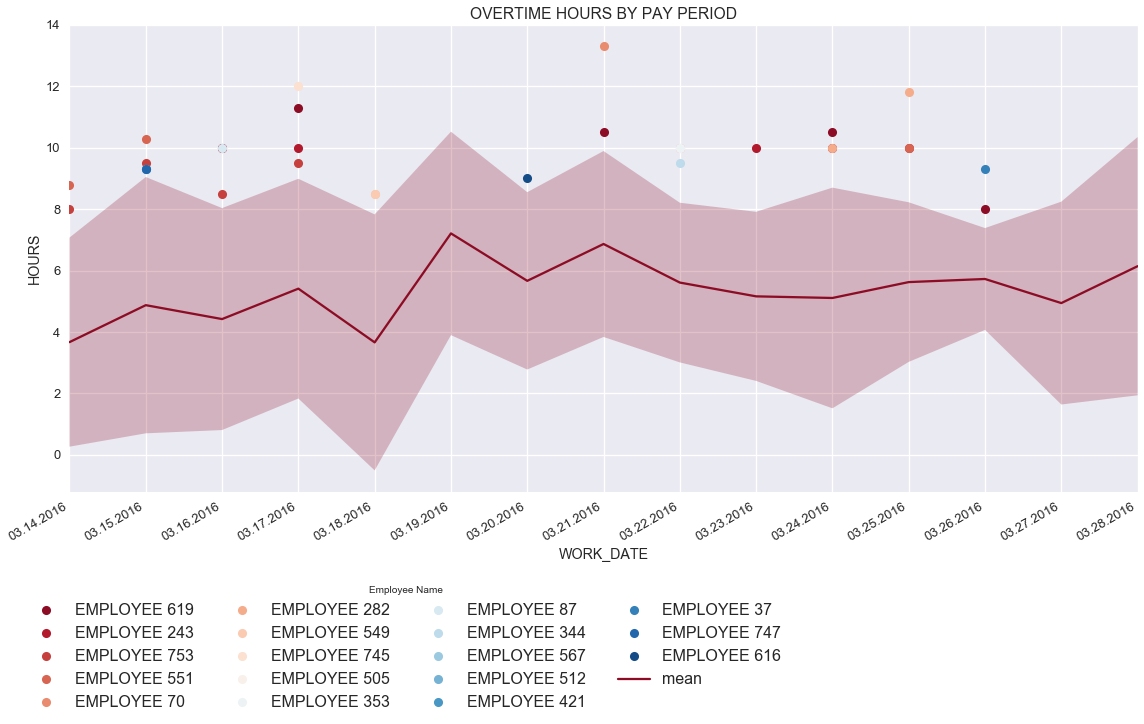

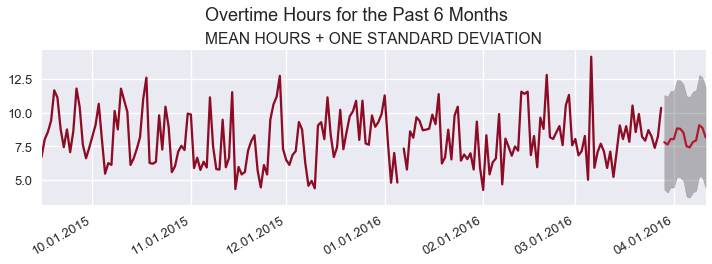

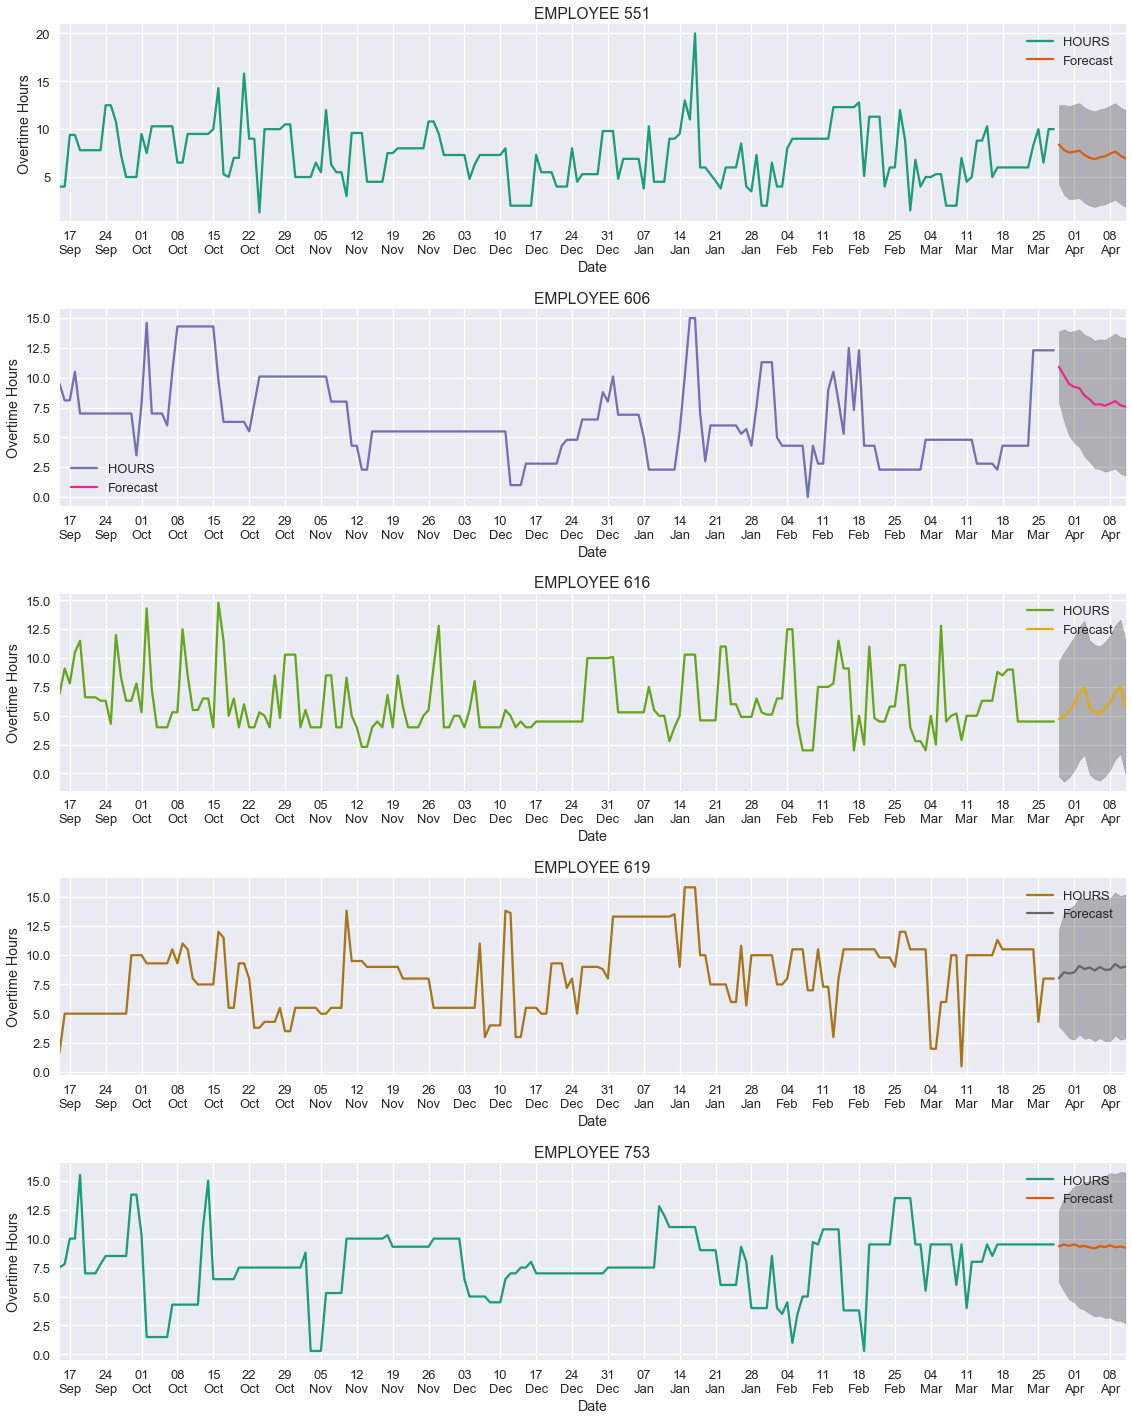

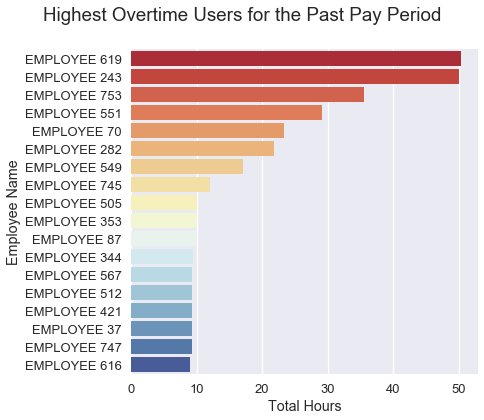

In [68]:
start_date = datetime.date(2016, 3, 14)
end_date = datetime.date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'


#use masks to create filtered dataframe, 
outlier_df = more_than_std_in_range(df, a, start_date, end_date, b)
relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
color_names = assign_colors(outlier_df)
mean_n_outliers_plot(relevant_df, outlier_df, color_names)

test_df = get_mplusstd(df, a, start_date, end_date, b)
plot_mplusstd(test_df,  order_vars =(1, 0, 1), seasonal_vars =(1, 1, 1, 7))

increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                     seasonal_vars = (1, 1, 1, 7))
generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                     seasonal_vars = (1, 1, 1, 7))

plot_bars_highOT(outlier_df, color_names)



In [69]:
send_email(SENDGRID_API_KEY, template_id, a, end_date)

Send email to what address?  --> ludbot@hotmail.com
202
b''
Server: nginx
Date: Tue, 25 Jul 2017 22:04:17 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: ZnUc6nq4SpiwT-5frlnqwg
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html




Wall time: 3.34 s


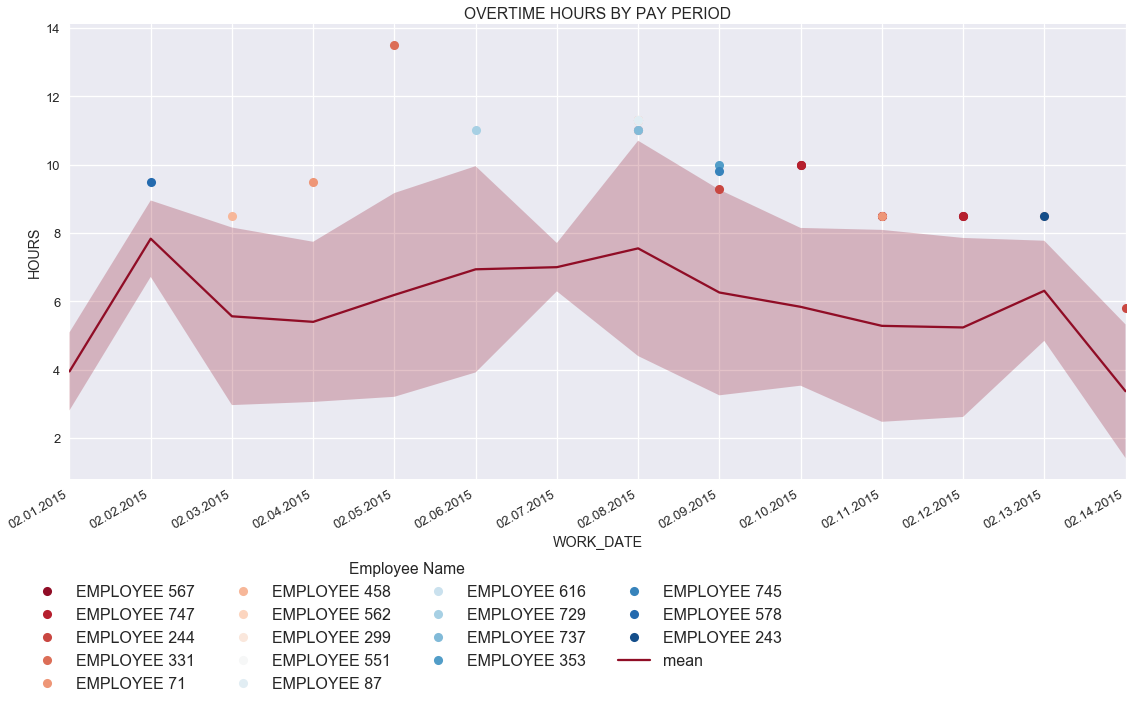

In [70]:
%%time
# import matplotlib.dates as dates


start_date = datetime.date(2015, 2, 1)
end_date = datetime.date(2015, 2, 14)
a = 'TRAF OFFICER II'
b = 'PA'


outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)

color_names = assign_colors(outlier_df)



mean_n_outliers_plot(relevant_df, outlier_df, color_names)

Wall time: 3.51 s


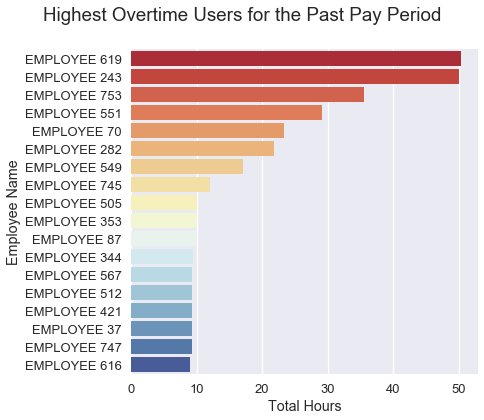

In [71]:
%%time
# import matplotlib.dates as dates


start_date = datetime.date(2016, 3, 14)
end_date = datetime.date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'


outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)

color_names = assign_colors(outlier_df)



(plot_bars_highOT(outlier_df, color_names))

In [72]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 3, 14)
end_date = date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))

Wall time: 2min 1s


In [73]:
increase_list

['EMPLOYEE 551',
 'EMPLOYEE 606',
 'EMPLOYEE 616',
 'EMPLOYEE 619',
 'EMPLOYEE 753']

In [74]:
%%time
filter_increasing(df, increase_list, start_date, end_date, a, b)

Wall time: 269 ms


['EMPLOYEE 551', 'EMPLOYEE 616', 'EMPLOYEE 619']

Wall time: 649 ms


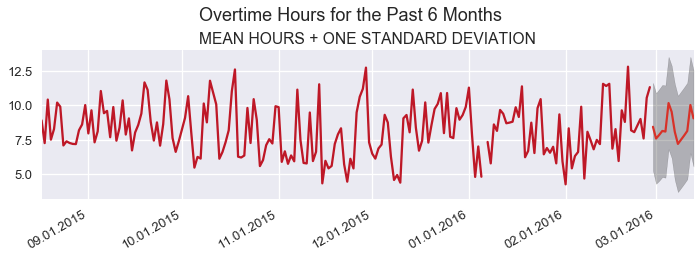

In [75]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 2, 14)
end_date = date(2016, 2, 28)
a = 'TRAF OFFICER II'
b = 'PA'

test_df = get_mplusstd(df, a, start_date, end_date, b)
plot_mplusstd(test_df, (1, 0, 1), (1, 1, 1, 7))

Wall time: 2min 25s


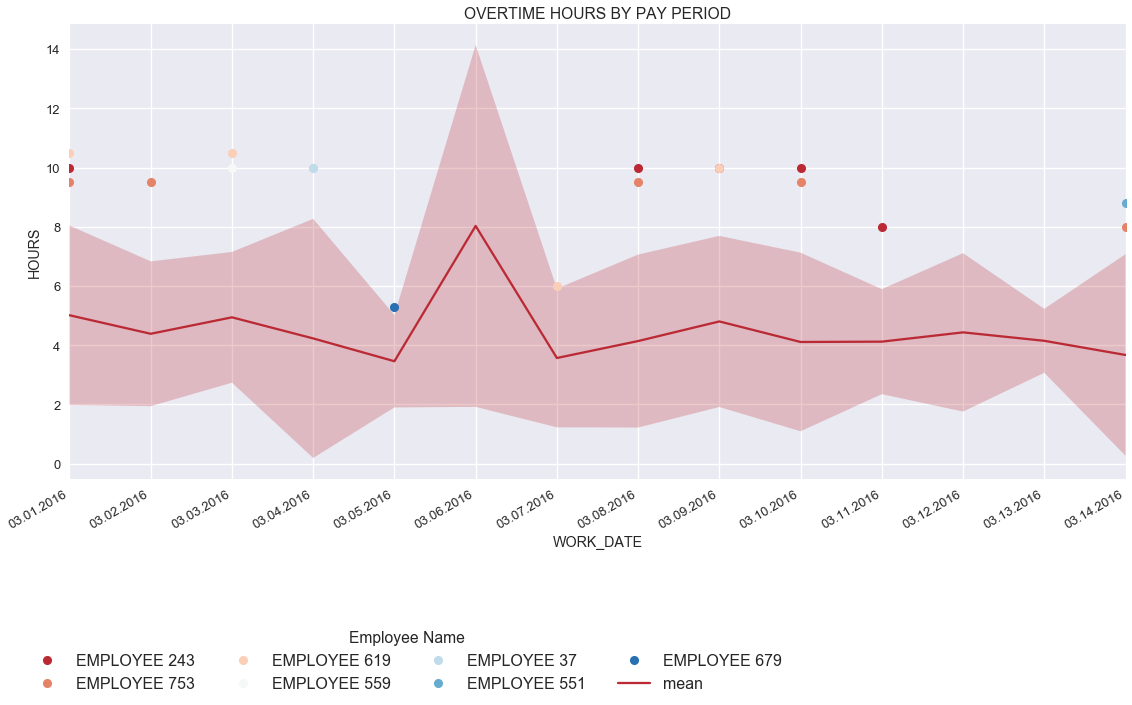

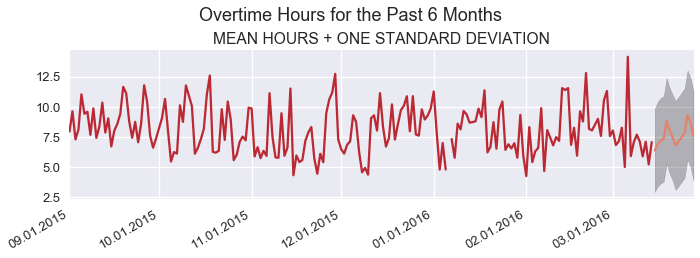

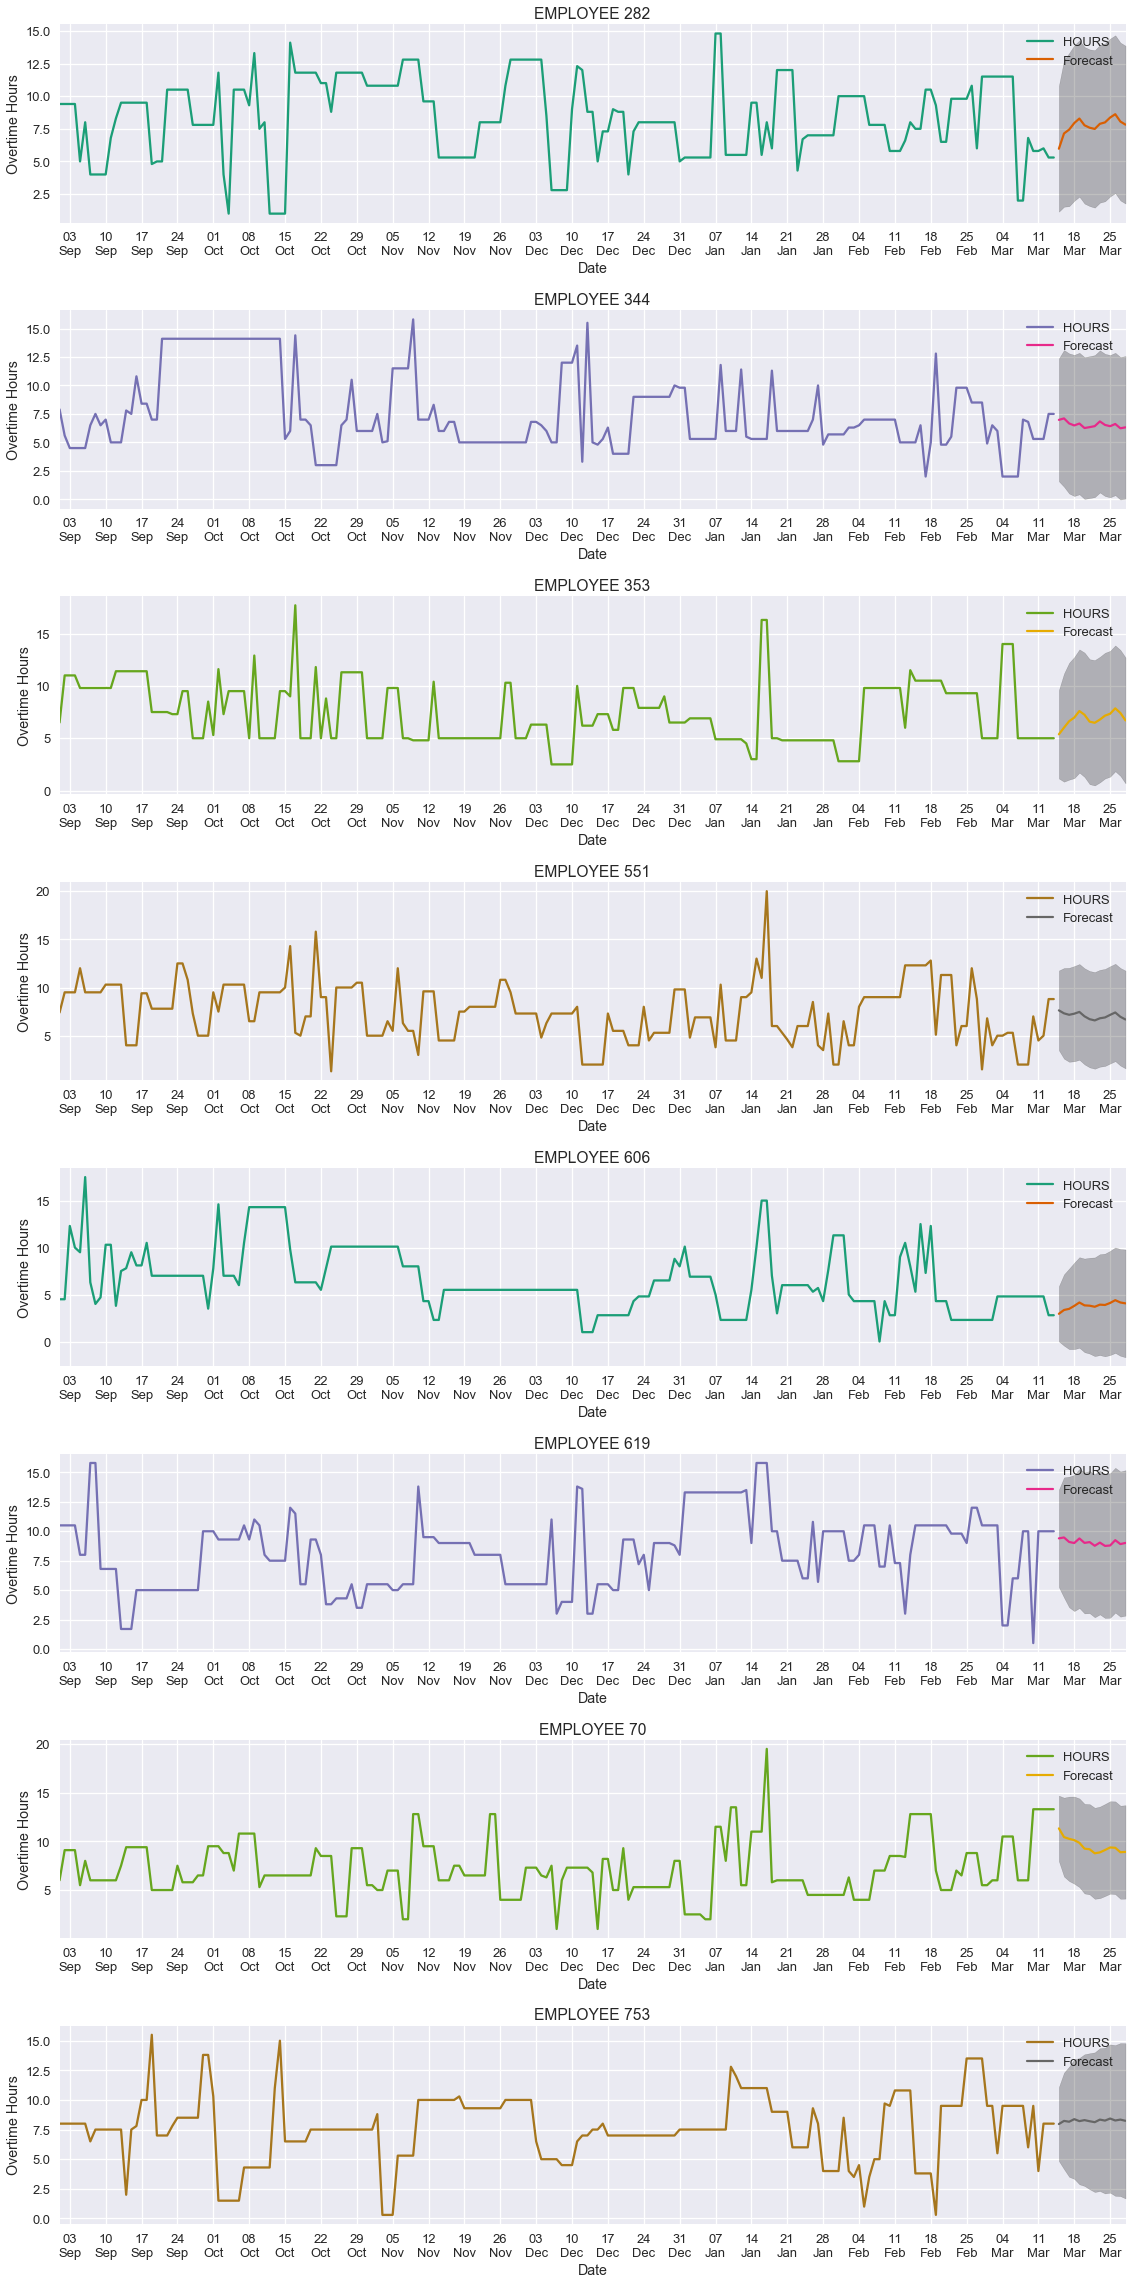

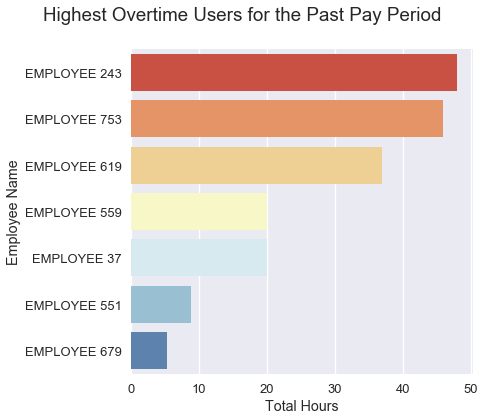

In [76]:
%%time

start_date = date(2016, 3, 1)
end_date = date(2016, 3, 14)
a = 'TRAF OFFICER II'
b = 'PA'


run_analysis(df, a, start_date, end_date, b)

In [77]:
send_email(SENDGRID_API_KEY, template_id, a, end_date)


Send email to what address?  --> ludbot@hotmail.com
202
b''
Server: nginx
Date: Tue, 25 Jul 2017 22:09:05 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: IwoRze1pTH2_oIYq1fROSQ
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html




Wall time: 2min 34s


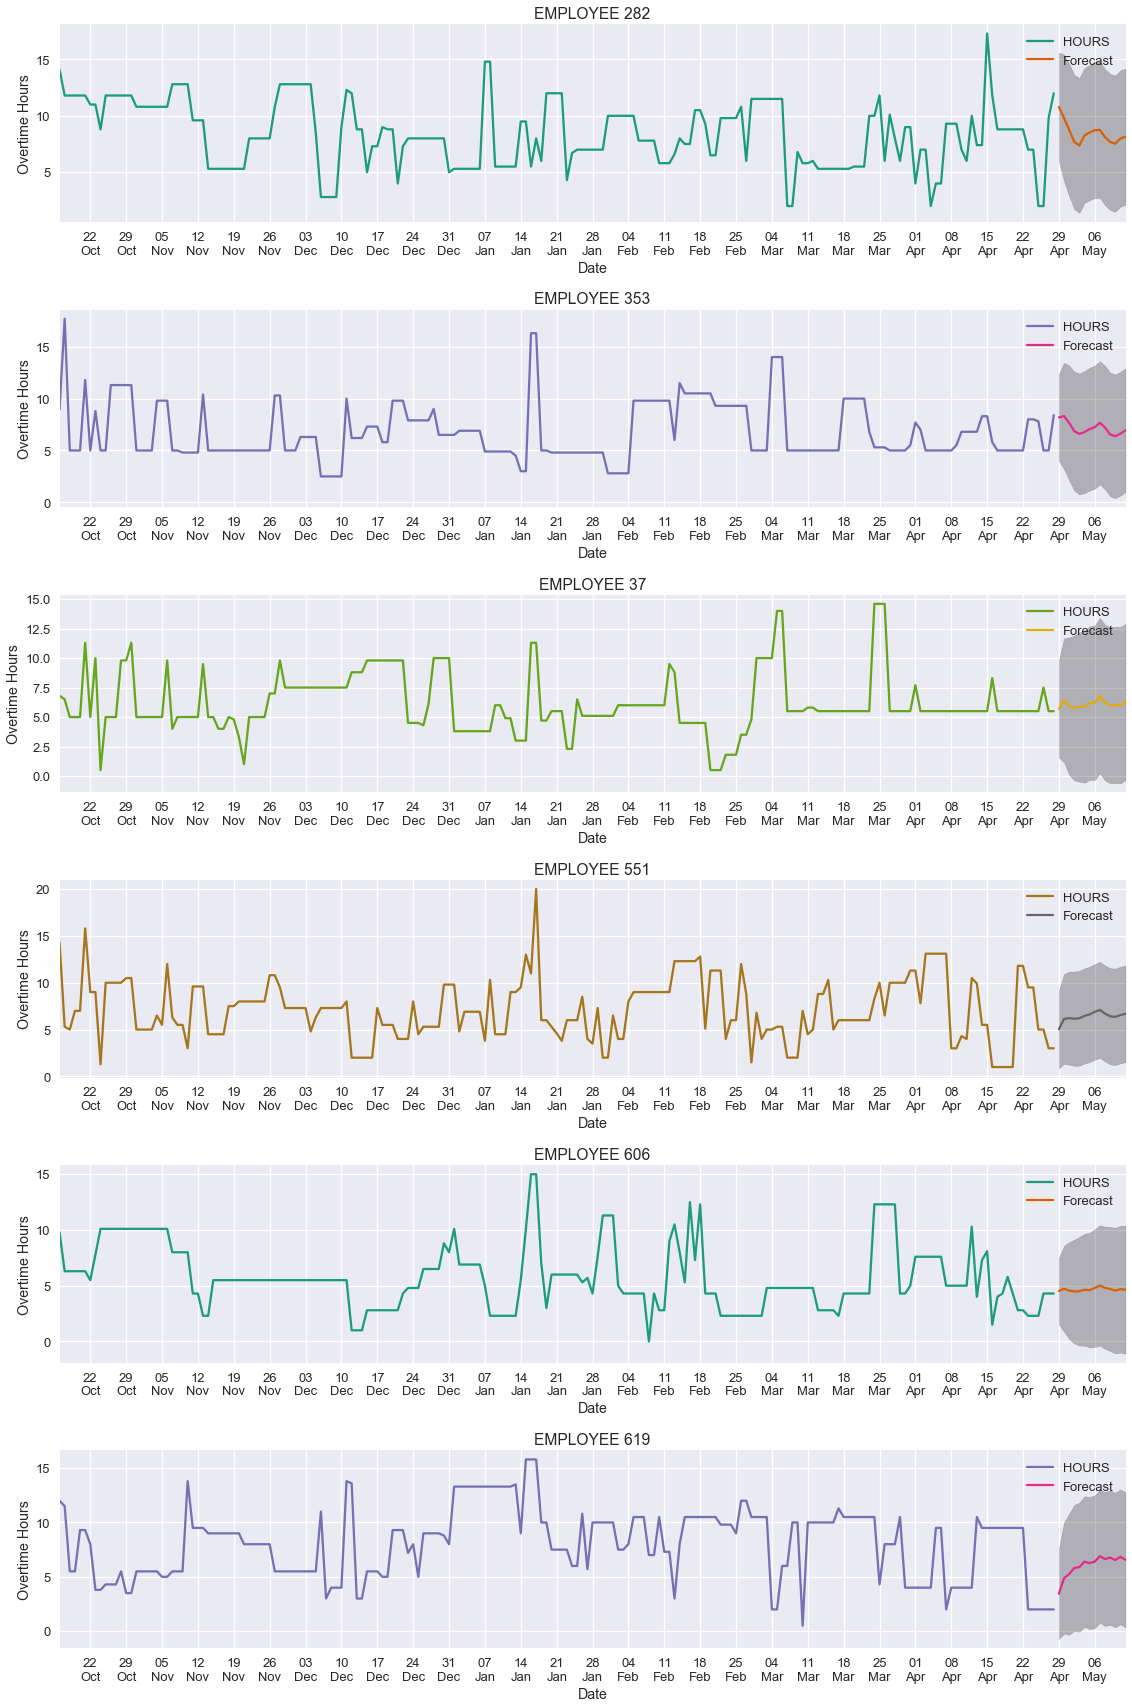

In [78]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 4, 14)
end_date = date(2016, 4, 28)
a = 'TRAF OFFICER II'
b = 'PA'

relevant_df = get_everybody_in(df, a, start_date, end_date, b).reset_index(drop=True)
increase_list = is_trending_too_high(df, relevant_df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))
generate_plot(increase_list, end_date, df, order_vars = (1, 1, 1),
                                         seasonal_vars = (1, 1, 1, 7))

Send email to what address?  --> ludbot@hotmail.com
202
b''
Server: nginx
Date: Tue, 25 Jul 2017 22:14:34 GMT
Content-Type: text/plain; charset=utf-8
Content-Length: 0
Connection: close
X-Message-Id: _awTpsMwTq67VAWMxrKsfg
X-Frame-Options: DENY
Access-Control-Allow-Origin: https://sendgrid.api-docs.io
Access-Control-Allow-Methods: POST
Access-Control-Allow-Headers: Authorization, Content-Type, On-behalf-of, x-sg-elas-acl
Access-Control-Max-Age: 600
X-No-CORS-Reason: https://sendgrid.com/docs/Classroom/Basics/API/cors.html


Wall time: 2min 53s


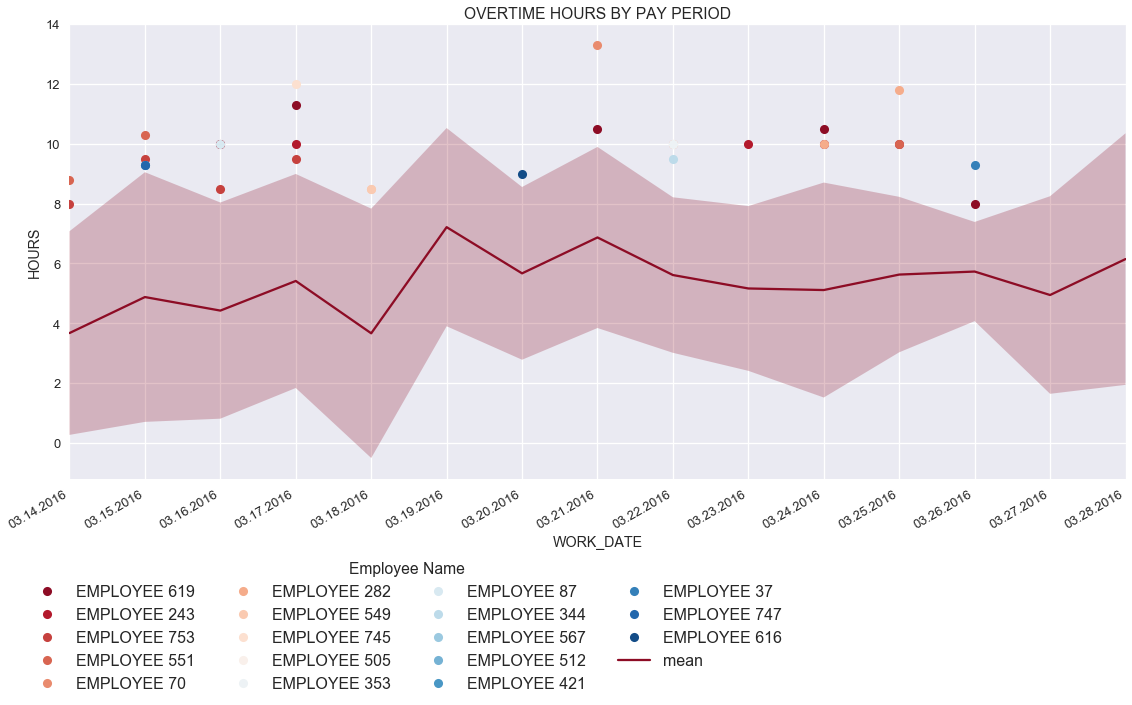

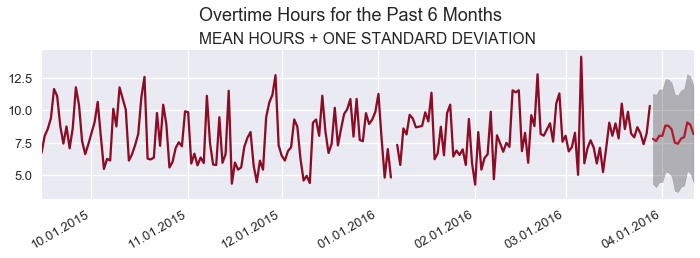

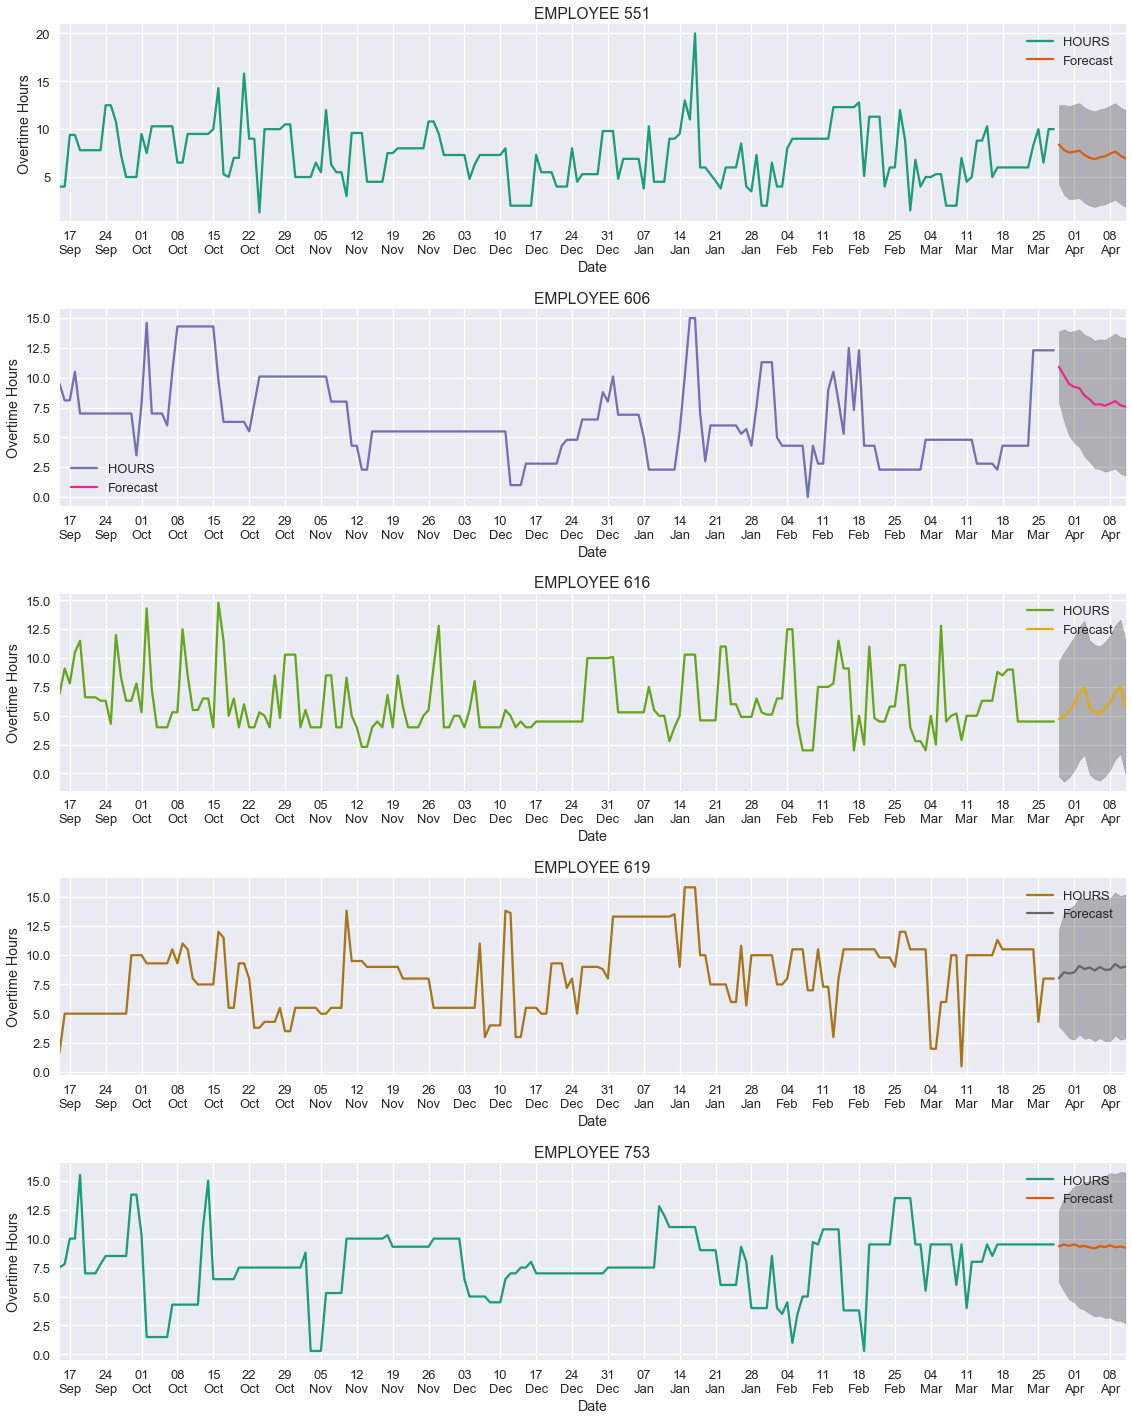

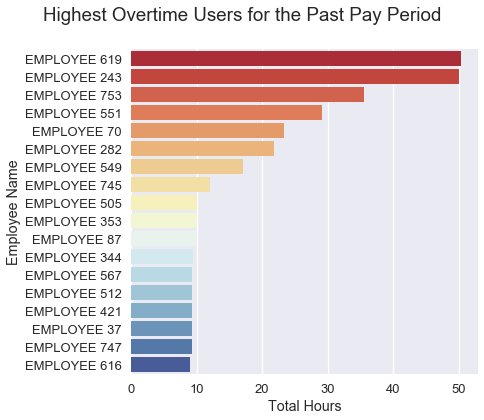

In [79]:
%%time
# import matplotlib.dates as dates


start_date = date(2016, 3, 14)
end_date = date(2016, 3, 28)
a = 'TRAF OFFICER II'
b = 'PA'

run_analysis(df, a, start_date, end_date, b)
send_email(SENDGRID_API_KEY, template_id, a, end_date)

In [85]:
start_date = date(2015, 6, 1)
end_date = date(2015, 6, 15)

a = 'TRAF OFFICER II'
b = 'PA'
outlier_df = more_than_std_in_range(df,a, start_date, end_date, b)

outlier_df.head(10)

,WORK_DATE,EMPLOYEE_NAME,HOURS
0,2015-06-04,EMPLOYEE 353,9.0
1,2015-06-05,EMPLOYEE 299,7.5
2,2015-06-05,EMPLOYEE 331,7.5
3,2015-06-05,EMPLOYEE 599,7.8
4,2015-06-06,EMPLOYEE 310,9.0
5,2015-06-06,EMPLOYEE 331,8.3
6,2015-06-06,EMPLOYEE 459,8.5
7,2015-06-06,EMPLOYEE 551,8.5
8,2015-06-07,EMPLOYEE 726,13.8
9,2015-06-08,EMPLOYEE 292,13.8


In [81]:
start_date = date(2015, 4, 1)
end_date = date(2015, 4, 15)

a = 'TRAF OFFICER II'
b = 'PA'

test_df = get_mplusstd(df, a, start_date, end_date, b)

mod = sm.tsa.statespace.SARIMAX(test_df,
                                order=(4, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2151      0.902      0.239      0.811      -1.552       1.983
ar.L2          0.0648      0.126      0.516      0.606      -0.181       0.311
ar.L3          0.0572      0.100      0.574      0.566      -0.138       0.252
ar.L4         -0.0316      0.101     -0.312      0.755      -0.231       0.167
ma.L1         -0.1429      0.889     -0.161      0.872      -1.885       1.600
ar.S.L7      1.23e-05      0.080      0.000      1.000      -0.158       0.158
ma.S.L7       -0.8890      0.062    -14.368      0.000      -1.010      -0.768
sigma2         2.5001      0.251      9.946      0.000       2.007       2.993


In [82]:
results.aic

691.10341863959468

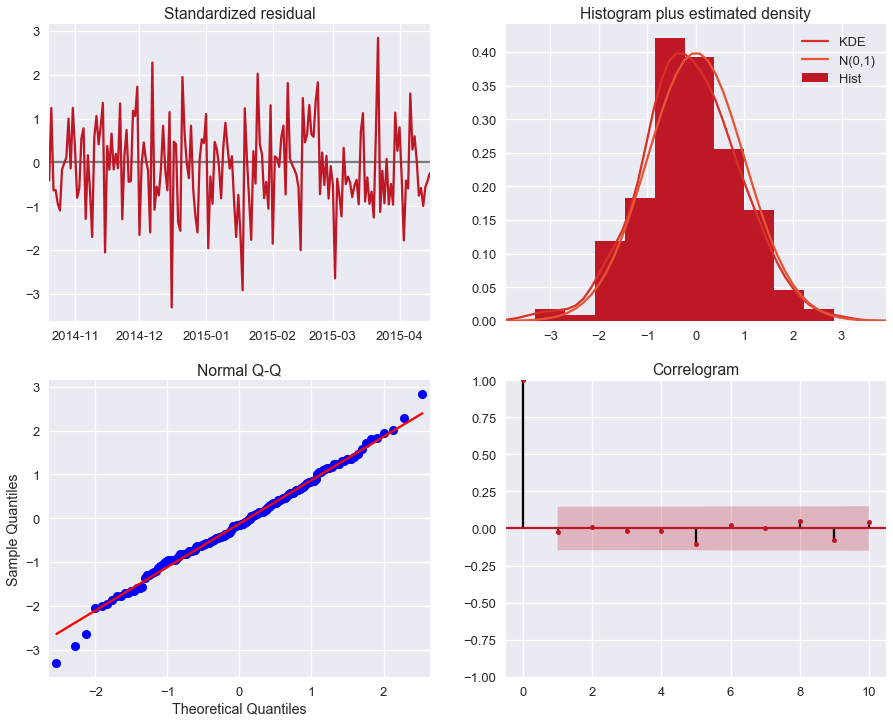

In [83]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [84]:
pred = results.get_forecast(steps=14)
y_forecasted = pred.predicted_mean
new_start = start_date + timedelta(days=14)
new_end = end_date + timedelta(days=14)
test_df = get_mplusstd(df, a, start_date, new_end, b)
y_truth = test_df[new_start:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.41
